**PREPARACIÓN DEL NOTEBOOK**

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score
#!pip install kneed
from kneed import KneeLocator

from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA, FactorAnalysis

#!pip install factor_analyzer
from factor_analyzer import FactorAnalyzer
.

## **EDA**

In [3]:
# Lectura de datos limpios
df = pd.read_csv("https://raw.githubusercontent.com/JavierBurgos-web/PROYECTO_ANALITICA_2da_entrega/main/dataset_limpio.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7711 entries, 0 to 7710
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   overall         7711 non-null   int64  
 1   age             7711 non-null   int64  
 2   height_cm       7711 non-null   int64  
 3   weight_kg       7711 non-null   int64  
 4   club_position   7711 non-null   int64  
 5   preferred_foot  7711 non-null   int64  
 6   pace            7711 non-null   float64
 7   shooting        7711 non-null   float64
 8   passing         7711 non-null   float64
 9   dribbling       7711 non-null   float64
 10  defending       7711 non-null   float64
 11  physic          7711 non-null   float64
 12  defending1      7711 non-null   int64  
 13  attacking1      7711 non-null   int64  
 14  skills1         7711 non-null   int64  
 15  mentality1      7711 non-null   int64  
 16  movement1       7711 non-null   int64  
 17  power           7711 non-null   i

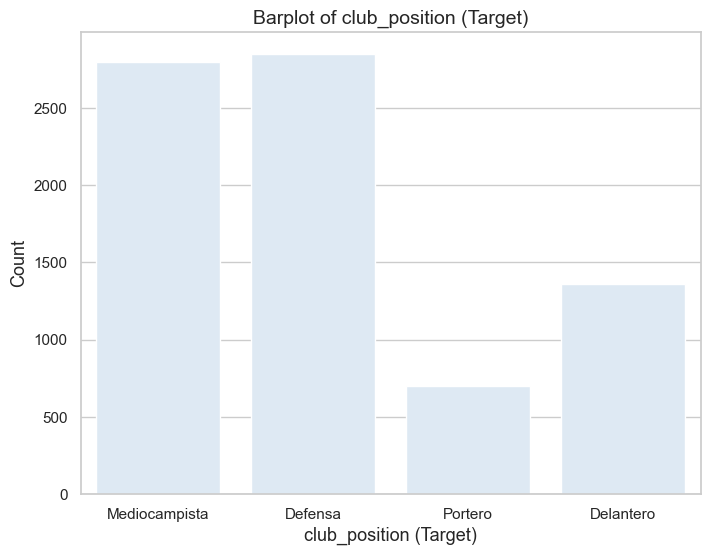

In [4]:
# Estilo de las gráficas
sns.set_theme(style='whitegrid', palette='Blues')

# Variable satisfacción
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='club_position', data=df)
plt.title('Barplot of club_position (Target)', fontsize=14)
plt.xlabel('club_position (Target)', fontsize=13)
plt.ylabel('Count', fontsize=13)

# Cambiamos las etiquetas del eje x
ax.set_xticks(range(4))
ax.set_xticklabels([
    'Mediocampista',
    'Defensa',
    'Portero',
    'Delantero'
])

plt.show()

In [5]:
categories = [0, 1, 2, 3]  # Lista de categorías que deseas analizar
categories_labels = ['Mediocampista', 'Defensa', 'Portero', 'Delantero']

category_dict = dict(zip(categories, categories_labels))  # Diccionario de correspondencia

for category in categories:
    
    mean_value = df[df['club_position'] == category].drop('club_position', axis=1).mean().mean()
    
    mean_value_rounded = round(mean_value, 3)  # Redondear a tres decimales
    category_label = category_dict[category]  # Obtener la etiqueta correspondiente
    print(f"Media para la categoría {category_label}: {mean_value_rounded}")


Media para la categoría Mediocampista: 150.427
Media para la categoría Defensa: 140.744
Media para la categoría Portero: 92.558
Media para la categoría Delantero: 145.163


La clase que mejor puntuación tiene es la de Mediocampista segida por la de Delantero, esto es evidente en los partidos puesto que son las dos posiciones que exigen mayores destrezas.

- **No debe haber mucha diferencia entre las medias** Se debería a datos atipicos

In [6]:
# Puntucación de cada variable respecto a cada clase
df.groupby('club_position')[df.columns.drop('club_position')].mean()

,overall,age,height_cm,weight_kg,preferred_foot,pace,shooting,passing,dribbling,defending,physic,defending1,attacking1,skills1,mentality1,movement1,power
club_position,,,,,,,,,,,,,,,,,
0,69.114367,26.341315,178.291994,72.523946,0.219442,69.296998,60.135096,65.272695,68.615797,55.073981,66.363117,163.590779,295.602931,320.950679,367.590422,348.492495,329.785561
1,68.228421,26.789474,182.805965,76.617895,0.330877,65.916140,42.521404,55.467719,58.870526,65.949474,71.035088,198.922456,253.314386,262.304561,334.124211,319.421404,310.030526
2,69.613409,28.460770,188.947218,82.727532,0.129815,69.000000,54.000000,58.000000,64.000000,56.000000,66.000000,44.202568,83.492154,95.606277,166.885877,230.429387,215.987161
3,69.267988,26.756241,181.280470,75.675477,0.182819,72.884728,67.429515,59.380323,68.566079,34.578561,66.582966,92.447871,312.309104,302.704112,347.392070,350.713656,339.618943


## **PRE PROCESAMIENTO DE DATOS**

In [7]:
df.shape

(7711, 18)

#### **NOTA:** Dependiendo de como vaya con el resultado final del algoritmo, se puede descartar las clases en 'club_position' que se concidere de menos valor 

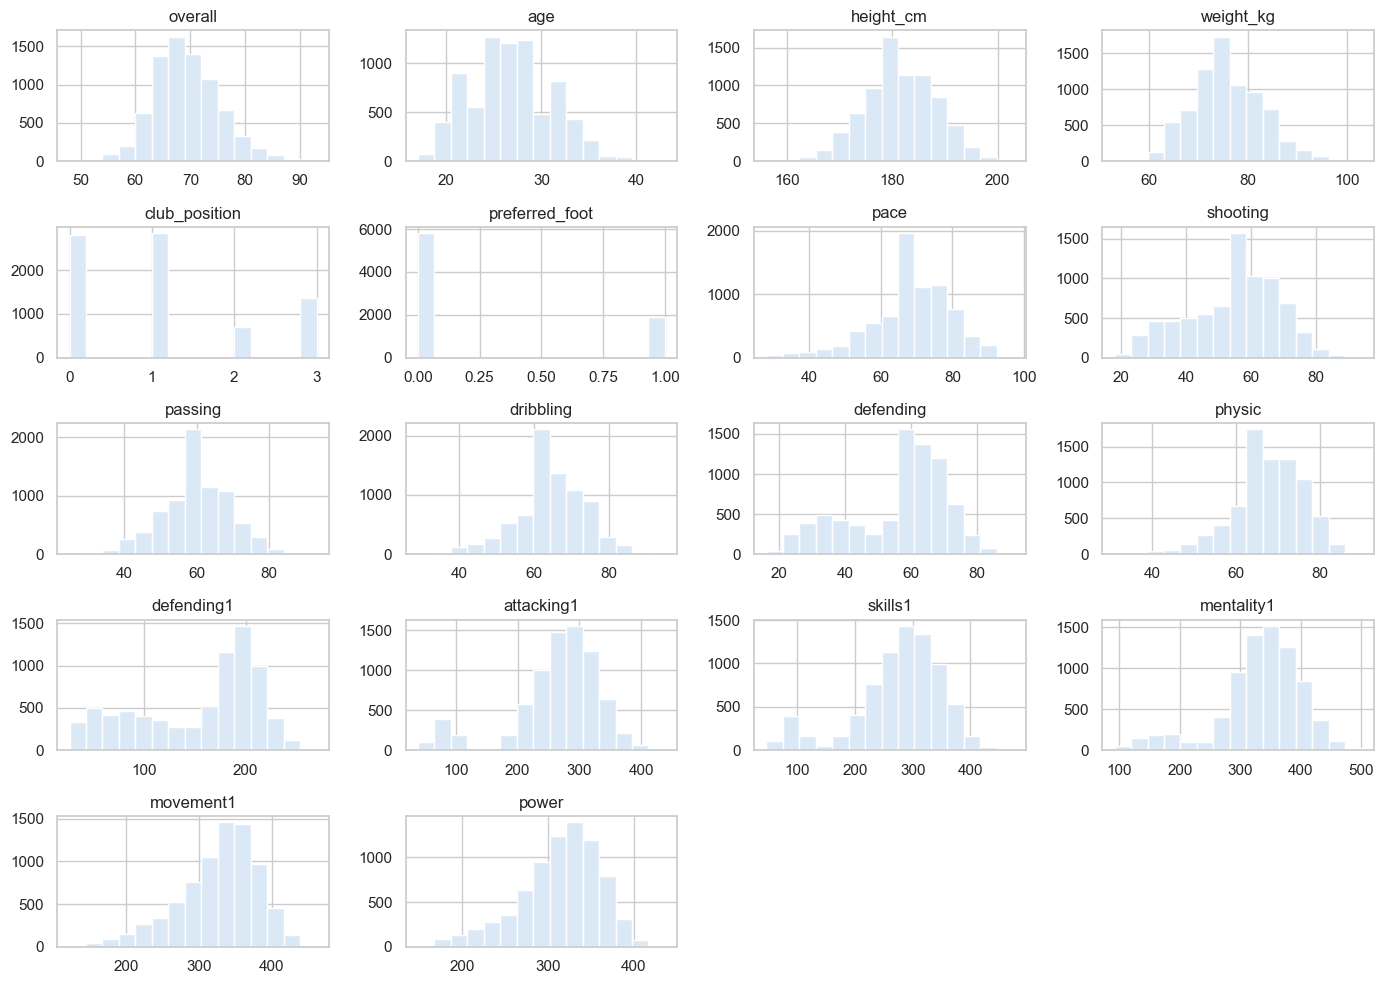

In [8]:
df.hist(figsize=(14,10), bins=15)
plt.tight_layout()
plt.show()

**TRATAMIENTO DE ATIPICOS**

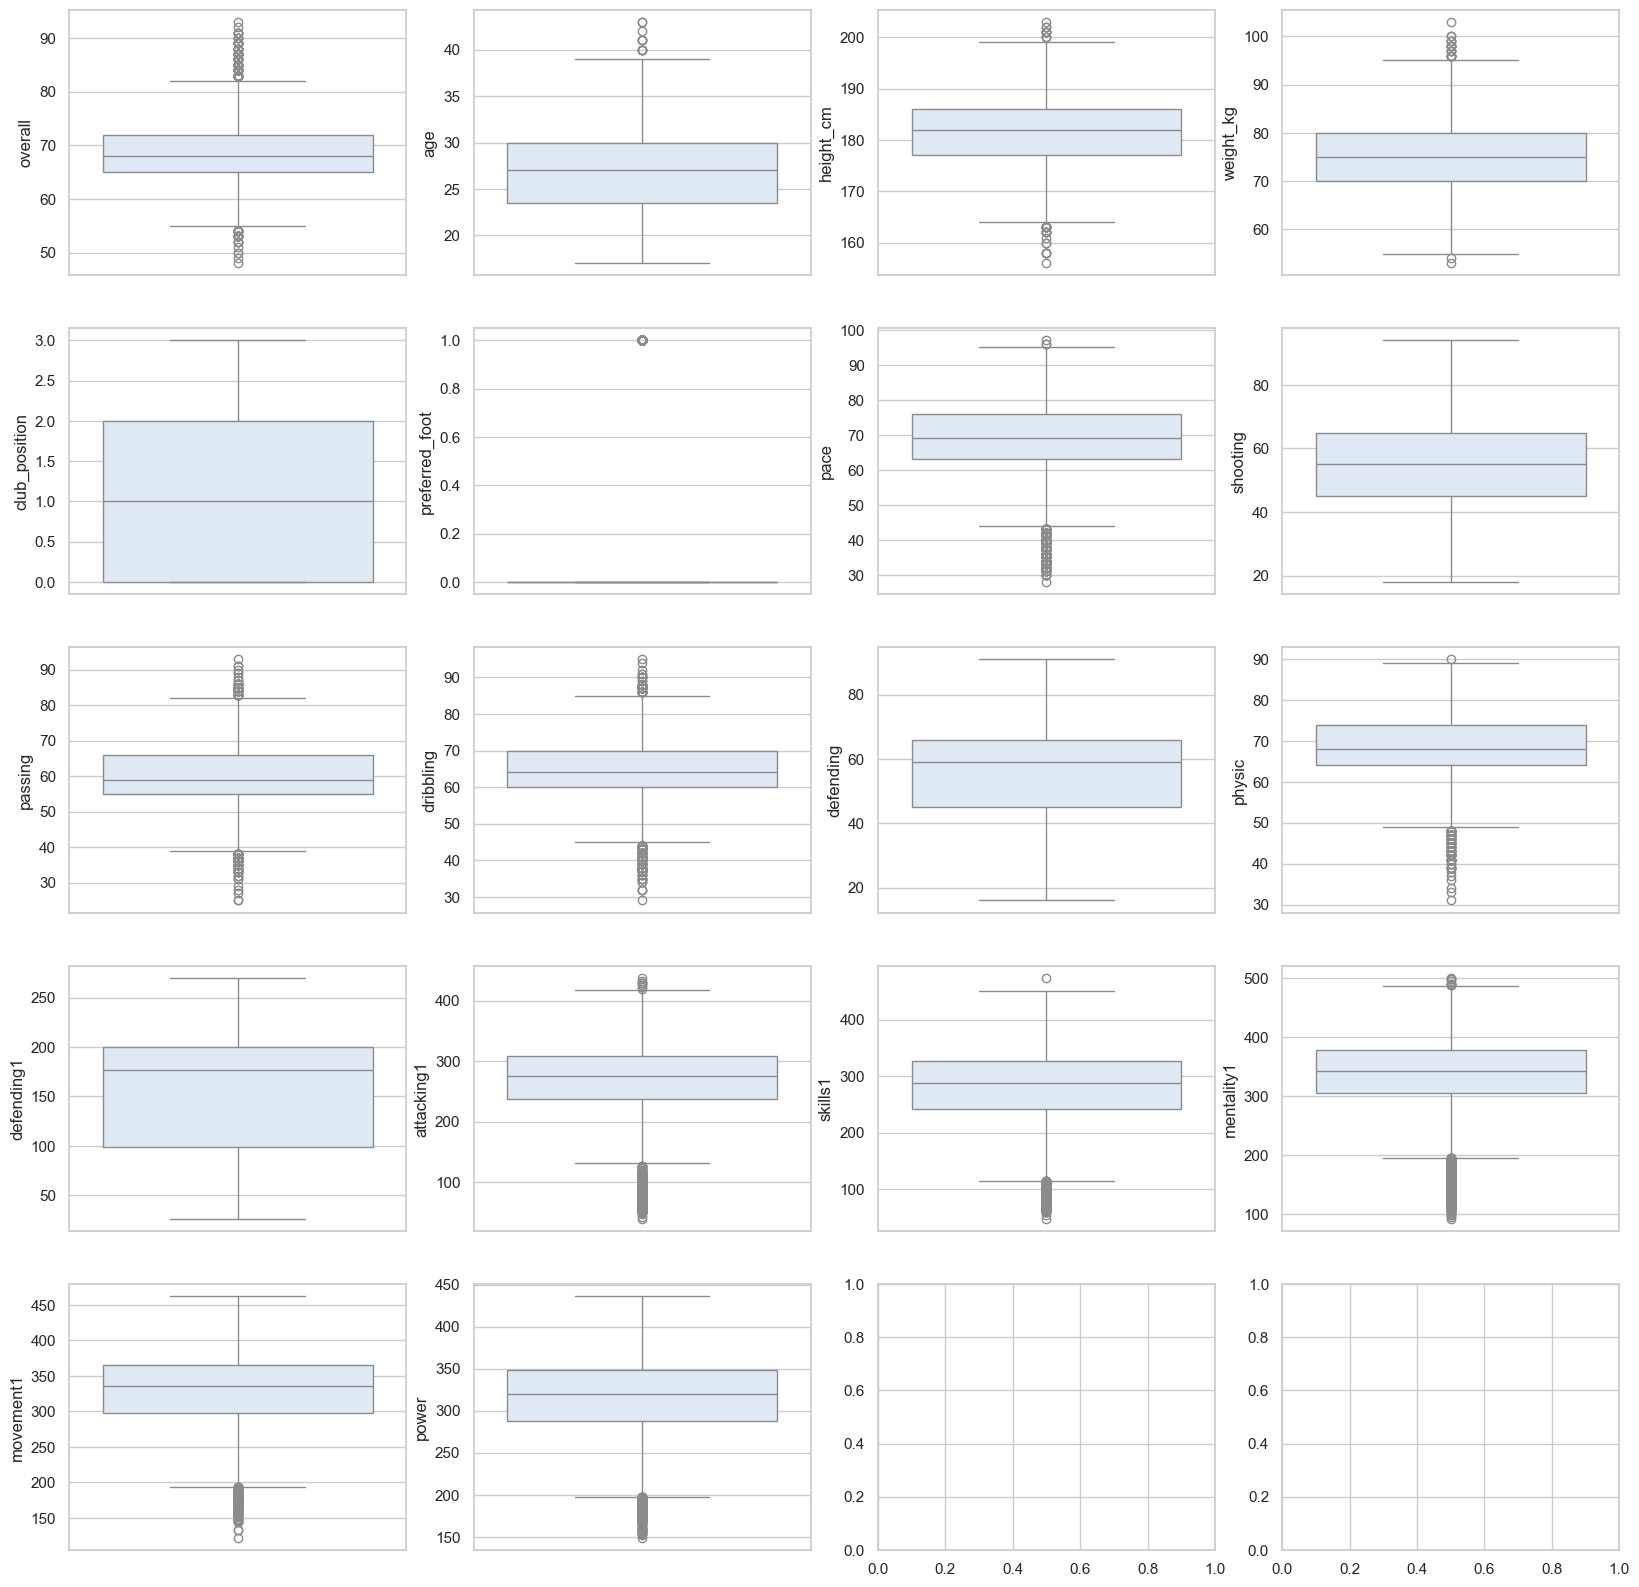

In [9]:
# Tratamiento de valores atípicos
df = df.copy()

# Sentar las bases de un "mosaico boxplot de 6x4 (para cubrir 22 variables)":
box_locs=pd.DataFrame(
{"vert":sorted(list(range(0,6))*4),
 "horiz":list(range(0,4))*6}
)

fig,axs=plt.subplots(ncols=4,nrows=5,figsize=(20,20))

for idx,i in enumerate(df.columns):
    sns.boxplot(y=df[i],ax=axs[box_locs.iloc[idx,0]][box_locs.iloc[idx,1]])

In [10]:
df.shape

(7711, 18)

In [11]:
## Basado en las observaciones de los atipicos realizmos un margen de limites para concervar los datos que esten mas cerca a los limites.
# Take indices of all the outliers:
outs_idx = [
            df[df['overall'] > 83]['overall'].index.astype('int'),
            df[df['overall'] < 38]['overall'].index.astype('int'),
            df[df['age'] > 39]['age'].index.astype('int'),
            df[df['height_cm'] > 199]['height_cm'].index.astype('int'),
            df[df['height_cm'] < 163]['height_cm'].index.astype('int'),
            df[df['weight_kg'] > 95]['weight_kg'].index.astype('int'),
            df[df['weight_kg'] < 53]['weight_kg'].index.astype('int'),
            df[df['pace'] > 96]['pace'].index.astype('int'),
            df[df['pace'] < 43]['pace'].index.astype('int'),
            df[df['passing'] > 82]['passing'].index.astype('int'),
            df[df['passing'] < 39]['passing'].index.astype('int'),
            df[df['dribbling'] > 85]['dribbling'].index.astype('int'),
            df[df['dribbling'] < 45]['dribbling'].index.astype('int'),
            df[df['physic'] > 89]['physic'].index.astype('int'),
            df[df['physic'] < 49]['physic'].index.astype('int'),
            df[df['attacking1'] > 410]['attacking1'].index.astype('int'),
            df[df['attacking1'] < 135]['attacking1'].index.astype('int'),
            df[df['skills1'] > 460]['skills1'].index.astype('int'),
            df[df['skills1'] < 110]['skills1'].index.astype('int'),
            df[df['mentality1'] > 490]['mentality1'].index.astype('int'),
            df[df['mentality1'] < 200]['mentality1'].index.astype('int'),
            df[df['movement1'] < 200]['movement1'].index.astype('int'),
            df[df['power'] < 200]['power'].index.astype('int'),
]

# Select unique ones and sort them:
outs_idx=pd.Series(sorted(np.concatenate(outs_idx))).unique()

# Drop these rows from 'train_df1_out' and 'train_df1, don't forget to RESET INDICES afterwards:
df.drop(index=outs_idx,inplace=True)
df.reset_index(drop=True,inplace=True) # 103837 rows left

In [12]:
df.shape

(6247, 18)

## **NIVEL UNO**

In [13]:
df_n1 = df.copy()

**DATASET ORIGINAL**

### **ALGORITMO K-MEANS**

In [14]:
# Número optimo de K
inertia_list = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=3, n_init=10)
    kmeans.fit(df_n1)
    inertia_list.append(kmeans.inertia_)

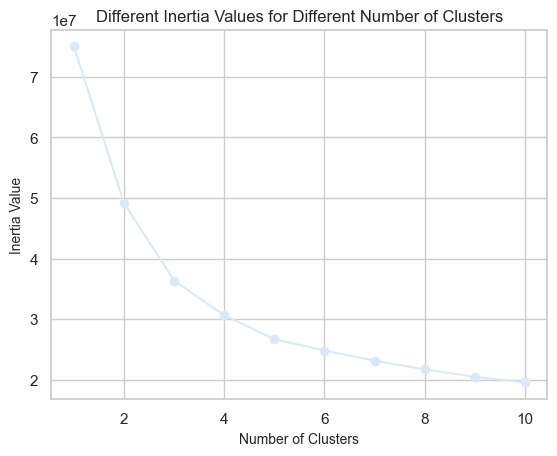

In [15]:
# plot the inertia curve
plt.plot(range(1,11),inertia_list)
plt.scatter(range(1,11),inertia_list)
plt.xlabel("Number of Clusters", size=10)
plt.ylabel("Inertia Value", size=10)
plt.title("Different Inertia Values for Different Number of Clusters", size=12)
plt.show()

In [16]:
## La siguiente librería reafirma la decicion de la seleccion de "codos" efectuada visualmente del grafico anterior
# Seleccion automatica del numero k 
kl_1 = KneeLocator(range(1, 11),
                 inertia_list, curve="convex",
                 direction="decreasing")
kl_1.elbow

3

In [17]:
kmeans_constants = {"init": "random", "n_init": 100, "max_iter": 500, "random_state": 42}

# --- Modelo K-means ---
model_kmeans = KMeans(n_clusters = 3, **kmeans_constants)
model_kmeans.fit(df_n1)

KMeans(init='random', max_iter=500, n_clusters=3, n_init=100, random_state=42)

**Evaluación del algoritmos**

**Calinski Harabasz Score:**

El índice Calinski-Harabasz se basa en la comparación de la relación ponderada entre la suma de los cuadrados (la medida de la separación del clúster) y la suma de los cuadrados dentro del clúster (la medida de cómo se empaquetan estrechamente los puntos dentro de un clúster).

Las soluciones de clúster con valores más grandes del índice corresponden a soluciones "mejores" que las soluciones de clúster con valores más pequeños.

In [18]:
# --- Evaluación del modelo kmeans ---
print(" ### K-MEANS ###")
print('Inertia: ', model_kmeans.inertia_)
print('Silhouette Score: ', silhouette_score(df_n1, model_kmeans.labels_))
print('Calinski harabasz score: ', calinski_harabasz_score(df_n1, model_kmeans.labels_))

 ### K-MEANS ###
Inertia:  36351346.43622626
Silhouette Score:  0.31243293321665555
Calinski harabasz score:  3319.9504314225


**Lectura de anterior salida.**
- Se cuenta con una inercia alta
- Un indice de siluetas bajo, entre más cercano a 1 mejor. Este indice informa que tan bien esta echa la agrupación, quíza en este caso el dataset no sea tan suseptible a realizar agrupaciones.
- Indice de referencia de Calinski. Se usa para comparar con otro algoritmo.

In [19]:
## Para obtener la etiqueta que da el algoritmo
# Predicción de los clusters
Cluster_1 = model_kmeans.fit_predict(df_n1)
Cluster_1

array([0, 2, 2, ..., 1, 1, 1])

In [20]:
# Vamos a adjuntar 'Cluster_1' como una nueva variable a 'df':
df_final = df_n1.copy()
df_final['Cluster_1']= Cluster_1

# A partir de ahora, sólo trabajaremos con "df_final"
df_final.head()

,overall,age,height_cm,weight_kg,club_position,preferred_foot,pace,shooting,passing,dribbling,defending,physic,defending1,attacking1,skills1,mentality1,movement1,power,Cluster_1
0,83,32,177,77,3,1,80.0,82.0,78.0,84.0,31.0,67.0,67,393,394,414,407,365,0
1,83,32,190,86,1,0,67.0,55.0,64.0,59.0,85.0,78.0,253,299,315,383,323,347,2
2,83,35,193,80,3,0,66.0,83.0,72.0,78.0,45.0,76.0,98,385,364,425,328,388,2
3,83,31,178,77,1,0,66.0,55.0,76.0,72.0,84.0,76.0,254,333,353,449,358,358,2
4,83,32,183,80,0,0,72.0,81.0,77.0,81.0,80.0,85.0,234,392,386,478,383,428,2


In [21]:
# NOTA: Se debe asignar una etiqueta a cada categoria de 'Cluster_1' para saber que nos esta informando
# Corroborar las etiquetas que se tiene
df_final.Cluster_1.unique()

array([0, 2, 1])

### **ALGORITMO DOS**

## **NIVEL DOS**

In [22]:
df_n2 = df.copy()

### **APLICACIÓN DE PCA**

In [23]:
#Cree un dataset reducido que proporcione el 95% de la varianza de entrada que debe explicarse
pca_1 = PCA(n_components=0.95).fit(df_n2)

#Veamos cuántas componentes ha conservado PCA:
pca_1.n_components_

5

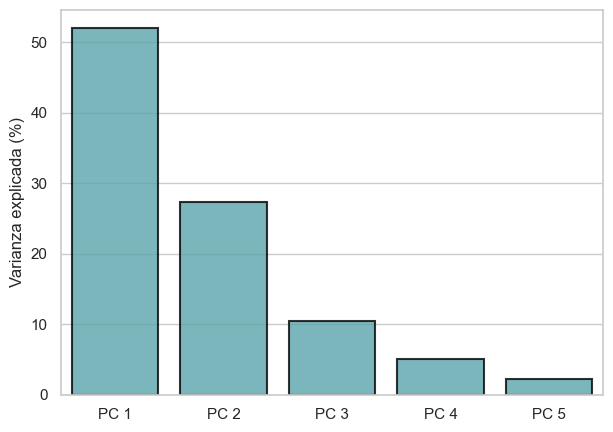

In [24]:
## Diagrama la varianza explicada para cada una de los 5 componentes
## Con este grafico se evalua como las componentes estan explicando las varianzas

# --- Varianza explicada --- 
PCA_variance_1 = pd.DataFrame({'Varianza explicada (%)':
                             pca_1.explained_variance_ratio_*100})

fig, ax = plt.subplots(1, 1, figsize = (7, 5))

bar = sns.barplot(x = ['PC ' + str(i) for i in range(1, 6)],
                  y = PCA_variance_1['Varianza explicada (%)'],
                  linewidth = 1.5, edgecolor = 'k', color = '#4bafb8',
                  alpha = 0.8)

plt.show()

**Lectura del anterior gráfico.** 
- La componente uno 'PC1' esta explicando aproximadamente el 53% de la varianza. 
- Si esta explicndo un porsentaje significativo, puesto que para llegar a una varianza explicada del 95% se necesitan de pocas variable (5 en este caso). Este comportamiento se debe a que las variables del dataset son numericas.

In [25]:
# Porsentaje de varianza explicada por cada componente
PCA_variance_1

,Varianza explicada (%)
0,51.999481
1,27.286647
2,10.416114
3,5.069587
4,2.309051


In [26]:
#Por último, transforme "df_n1" de 18 columnas X_pca
X_pca_1 = pca_1.fit_transform(df_n1)
X_pca_1 #Dataset ya transformado

array([[-1.89206804e+02,  8.10349691e+01,  3.88694439e-02,
         9.54921804e+00,  1.67629391e+01],
       [-2.16725958e+01, -1.02153956e+02,  1.23605575e+01,
        -2.86317597e+00, -8.34450881e+00],
       [-1.51781562e+02,  3.24895226e+01,  7.56539369e+01,
         6.80986387e+00,  1.55961988e+01],
       ...,
       [ 1.35866936e+02,  1.40785148e+02, -2.93099704e+01,
        -1.41196591e+01,  1.65307480e+00],
       [ 1.39543389e+02,  5.89852113e+01,  1.72750218e+01,
         2.37698302e+01,  1.35441171e+01],
       [ 1.66695100e+02,  3.70282561e+01,  2.45096935e+01,
         3.76564675e+01,  1.26423290e+01]])

**Interpretación.** No se tiene una lectura tan sencilla de las componentes, pero se puede identificar la influencia de las variables dentro de cada componente, esto es más interpretable en los graficos de los clustering.

### **ALGORITMO K-MEANS**

#### **DATASET ORIGINAL**

In [27]:
# Número optimo de K
inertia_list_1 = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=3, n_init=10)
    kmeans.fit(df_n2)
    inertia_list_1.append(kmeans.inertia_)

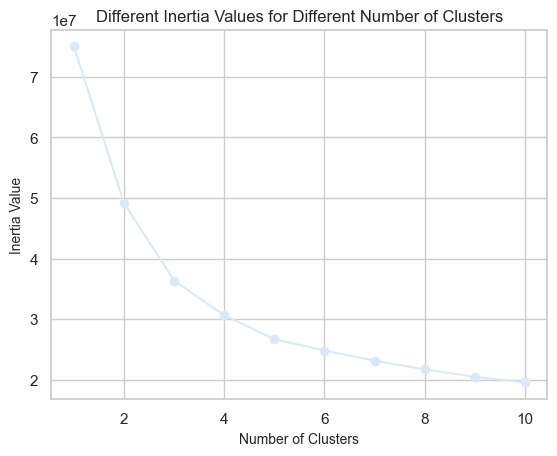

In [28]:
# plot the inertia curve
plt.plot(range(1,11),inertia_list_1)
plt.scatter(range(1,11),inertia_list_1)
plt.xlabel("Number of Clusters", size=10)
plt.ylabel("Inertia Value", size=10)
plt.title("Different Inertia Values for Different Number of Clusters", size=12)
plt.show()

In [29]:
## La siguiente librería reafirma la decicion de la seleccion de "codos" efectuada visualmente del grafico anterior
# Seleccion automatica del numero k 
kl_1 = KneeLocator(range(1, 11),
                 inertia_list_1, curve="convex",
                 direction="decreasing")
kl_1.elbow

3

In [30]:
kmeans_constants = {"init": "random", "n_init": 100, "max_iter": 500, "random_state": 42}

# --- Modelo K-means ---
model_kmeans = KMeans(n_clusters = 3, **kmeans_constants)
model_kmeans.fit(df_n2)

KMeans(init='random', max_iter=500, n_clusters=3, n_init=100, random_state=42)

**Evaluación del algoritmos**

**Calinski Harabasz Score:**

El índice Calinski-Harabasz se basa en la comparación de la relación ponderada entre la suma de los cuadrados (la medida de la separación del clúster) y la suma de los cuadrados dentro del clúster (la medida de cómo se empaquetan estrechamente los puntos dentro de un clúster).

Las soluciones de clúster con valores más grandes del índice corresponden a soluciones "mejores" que las soluciones de clúster con valores más pequeños.

In [31]:
# --- Evaluación del modelo kmeans ---
print(" ### K-MEANS ###")
print('Inertia: ', model_kmeans.inertia_)
print('Silhouette Score: ', silhouette_score(df_n2, model_kmeans.labels_))
print('Calinski harabasz score: ', calinski_harabasz_score(df_n2, model_kmeans.labels_))

 ### K-MEANS ###
Inertia:  36351346.43622626


Silhouette Score:  0.31243293321665555
Calinski harabasz score:  3319.9504314225


**Lectura de anterior salida.**
- Se cuenta con una inercia alta
- Un indice de siluetas bajo, entre más cercano a 1 mejor. Este indice informa que tan bien esta echa la agrupación, quíza en este caso el dataset no sea tan suseptible a realizar agrupaciones.
- Indice de referencia de Calinski. Se usa para comparar con otro algoritmo.

**CONCLUSIÓN HASTA EL MOMENTO** 

El algoritmo de kmeans no esta haciendo una buena agrupación, esto se debe quiza a la información del dataset

In [32]:
## Para obtener la etiqueta que da el algoritmo
# Predicción de los clusters
Cluster_1 = model_kmeans.fit_predict(df_n2)
Cluster_1

array([0, 2, 2, ..., 1, 1, 1])

In [33]:
# Vamos a adjuntar 'Cluster_1' como una nueva variable a 'df':
df_final = df_n2.copy()
df_final['Cluster_1']= Cluster_1

# A partir de ahora, sólo trabajaremos con "df_final"
df_final.head()

,overall,age,height_cm,weight_kg,club_position,preferred_foot,pace,shooting,passing,dribbling,defending,physic,defending1,attacking1,skills1,mentality1,movement1,power,Cluster_1
0,83,32,177,77,3,1,80.0,82.0,78.0,84.0,31.0,67.0,67,393,394,414,407,365,0
1,83,32,190,86,1,0,67.0,55.0,64.0,59.0,85.0,78.0,253,299,315,383,323,347,2
2,83,35,193,80,3,0,66.0,83.0,72.0,78.0,45.0,76.0,98,385,364,425,328,388,2
3,83,31,178,77,1,0,66.0,55.0,76.0,72.0,84.0,76.0,254,333,353,449,358,358,2
4,83,32,183,80,0,0,72.0,81.0,77.0,81.0,80.0,85.0,234,392,386,478,383,428,2


In [34]:
# NOTA: Se debe asignar una etiqueta a cada categoria de 'Cluster_1' para saber que nos esta informando
# Corroborar las etiquetas que se tiene
df_final.Cluster_1.unique()

array([0, 2, 1])

#### **DATASET REDUCIDO**

In [87]:
# Número optimo de K
inertia_list_2 = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=3, n_init=10)
    kmeans.fit(X_pca_1)
    inertia_list_2.append(kmeans.inertia_)

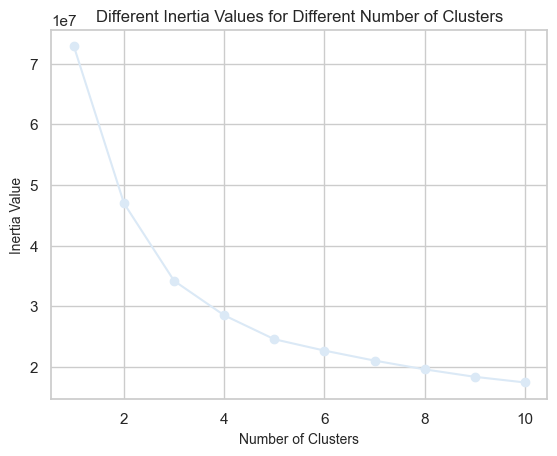

In [88]:
# plot the inertia curve
plt.plot(range(1,11),inertia_list_2)
plt.scatter(range(1,11),inertia_list_2)
plt.xlabel("Number of Clusters", size=10)
plt.ylabel("Inertia Value", size=10)
plt.title("Different Inertia Values for Different Number of Clusters", size=12)
plt.show()

In [89]:
## La siguiente librería reafirma la decicion de la seleccion de "codos" efectuada visualmente del grafico anterior
# Seleccion automatica del numero k 
kl_2 = KneeLocator(range(1, 11),
                 inertia_list_2, curve="convex",
                 direction="decreasing")
kl_2.elbow

3

In [90]:
kmeans_constants = {"init": "random", "n_init": 100, "max_iter": 500, "random_state": 42}

# --- Modelo K-means ---
model_kmeans_pca = KMeans(n_clusters = 3, **kmeans_constants)
model_kmeans_pca.fit(X_pca_1)

KMeans(init='random', max_iter=500, n_clusters=3, n_init=100, random_state=42)

In [91]:
# --- Evaluación del modelo kmeans ---
print(" ### K-MEANS ###")
print('Inertia: ', model_kmeans_pca.inertia_)
print('Silhouette Score: ', silhouette_score(X_pca_1, model_kmeans_pca.labels_))
print('Calinski harabasz score: ', calinski_harabasz_score(X_pca_1, model_kmeans_pca.labels_))

 ### K-MEANS ###
Inertia:  34170219.673197106
Silhouette Score:  0.3265230246043206
Calinski harabasz score:  3531.097437562411


**COMPARACIÓN DE RESULTADOS DEL ALGORITMO EJECUTADO EN DATASET ORIGINAL Y DATASET REDUCIDO**

- La reducción de la dimensionalidad si tiene un efecto en la metrica de la inercia, puesto que disminuye, es bueno por que se esta usando menos variables, el factor indica que estan menos correlacionadas.

- El indice de silueta es mayor, lo que indica un mejor resultado.

- El indice de Calinski también es más alto.

Estas mericas al ser mayores, informan que el modelo esta mejor respecto al modelo anterior. Esto indica que si se puede lograr una agrupación, no la ideal, pero sí una agrupación que cumpla que los clostering esten separados unos de otros y que no haya solapamiento.

In [93]:
## Analizarlo vizualmente 
# Predicción de los clusters
Cluster_2 = model_kmeans.fit_predict(X_pca_1)

df_final['Cluster_2']= Cluster_2

# A partir de ahora, sólo trabajaremos con "df_final"
df_final.head(3)

,overall,age,height_cm,weight_kg,club_position,preferred_foot,pace,shooting,passing,dribbling,defending,physic,defending1,attacking1,skills1,mentality1,movement1,power,Cluster_1,Cluster_2
0,83,32,177,77,3,1,80.0,82.0,78.0,84.0,31.0,67.0,67,393,394,414,407,365,0,0
1,83,32,190,86,1,0,67.0,55.0,64.0,59.0,85.0,78.0,253,299,315,383,323,347,2,2
2,83,35,193,80,3,0,66.0,83.0,72.0,78.0,45.0,76.0,98,385,364,425,328,388,2,2


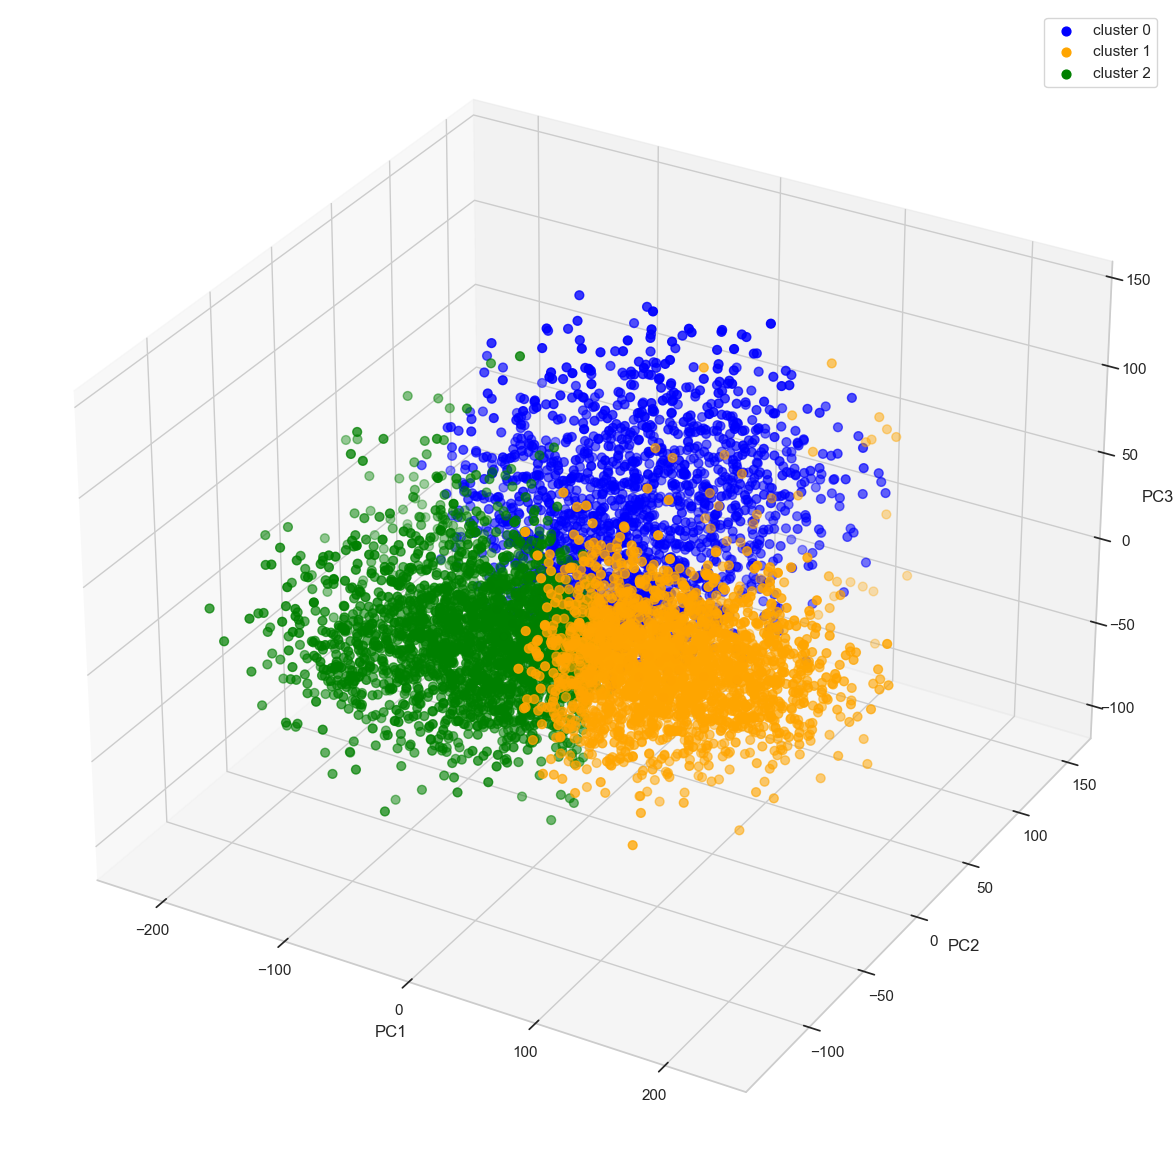

In [95]:
### Gráfico de dispersión respecto al 'cluster_2'
# 3d scatterplot using matplotlib

fig = plt.figure(figsize = (15,15))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_pca_1[Cluster_2 == 0,0],X_pca_1[Cluster_2 == 0,1],X_pca_1[Cluster_2 == 0,2], s = 40 , color = 'blue', label = "cluster 0")
ax.scatter(X_pca_1[Cluster_2 == 1,0],X_pca_1[Cluster_2 == 1,1],X_pca_1[Cluster_2 == 1,2], s = 40 , color = 'orange', label = "cluster 1")
ax.scatter(X_pca_1[Cluster_2 == 2,0],X_pca_1[Cluster_2 == 2,1],X_pca_1[Cluster_2 == 2,2], s = 40 , color = 'green', label = "cluster 2")
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.legend()
plt.show()

**INTERPRETACIÓN DEL ANTERIOR GRÁFICO**

- No hay separación clara entre los clusters, estan muy concentrados unos a otros, sin embargo si detecta grupos, pero ello se ve reflejado en una metrica tan baja en el indice de silueta.

- El 'cluster 0' representado por el color azul, y el 'cluster 1' se estan solapando, es visible que hay observaciones del 'cluster 1' que estan sobre el 'cluster 0'. Ello también afectó las metricas que se obtuvo en la evaluación. 

- Sin embargo, con la agrupación que se tiene se pueden realizar concluciones respecto a la manera en que se estan formando los grupos, en este caso particular grupos de jugadores que tienen caracteristicas que los diferencian. 

### **ALGORITMO DOS**

##### **DATASET ORIGINAL**

##### **DATASET REDUCIDO**

## **NIVEL TRES**

In [35]:
df_n3 = df.copy()

### **APLICACIÓN DE PCA**

In [38]:
#Cree un dataset reducido que proporcione el 75% de la varianza de entrada que debe explicarse
pca_2 = PCA(n_components=0.75).fit(df_n3)

#Veamos cuántas componentes ha conservado PCA:
pca_2.n_components_

2

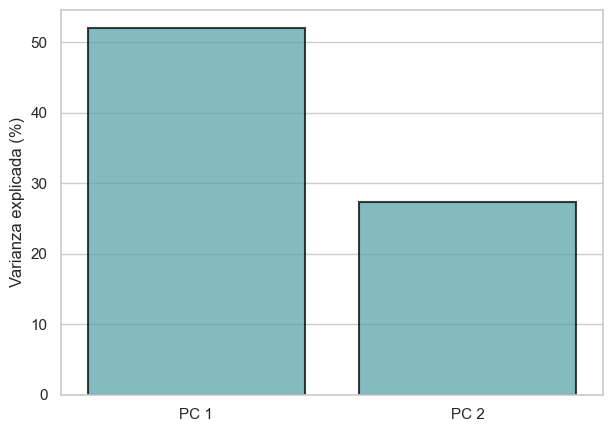

In [43]:
## Diagrama la varianza explicada para cada una de los 5 componentes
## Con este grafico se evalua como las componentes estan explicando las varianzas

# --- Varianza explicada --- 
PCA_variance_2 = pd.DataFrame({'Varianza explicada (%)':
                             pca_2.explained_variance_ratio_*100})

fig, ax = plt.subplots(1, 1, figsize = (7, 5))

bar = sns.barplot(x = ['PC ' + str(i) for i in range(1, 3)],
                  y = PCA_variance_2['Varianza explicada (%)'],
                  linewidth = 1.5, edgecolor = 'k', color = '#4bafb8',
                  alpha = 0.75)

plt.show()

**Lectura del anterior gráfico.** 
- La componente uno 'PC1' esta explicando aproximadamente el 53% de la varianza. 
- Si esta explicndo un porsentaje significativo, puesto que para llegar a una varianza explicada del 75% se necesitan de pocas variables (2 en este caso). Este comportamiento se debe a que las variables del dataset son numericas.

In [45]:
# Porsentaje de varianza explicada por cada componente
PCA_variance_2

,Varianza explicada (%)
0,51.999481
1,27.286647


In [47]:
#Por último, transforme "df_n1" de 18 columnas X_pca
X_pca_2 = pca_2.fit_transform(df_n2)
X_pca_2 #Dataset ya transformado

array([[-189.20680396,   81.03496907],
       [ -21.67259583, -102.1539565 ],
       [-151.78156169,   32.48952261],
       ...,
       [ 135.86693606,  140.78514801],
       [ 139.5433887 ,   58.98521128],
       [ 166.69509986,   37.02825613]])

**Interpretación.** No se tiene una lectura tan sencilla de las componentes, pero se puede identificar la influencia de las variables dentro de cada componente, esto es más interpretable en los graficos de los clustering.

### **ALGORITMO K-MEANS**

#### **DATASET ORIGINAL**

In [48]:
# Número optimo de K
inertia_list_2 = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=3, n_init=10)
    kmeans.fit(df_n3)
    inertia_list_2.append(kmeans.inertia_)

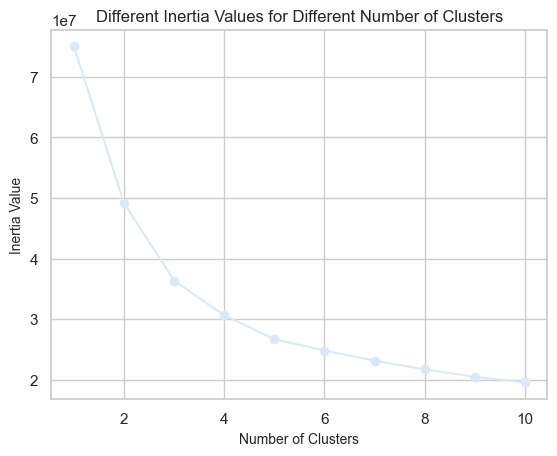

In [49]:
# plot the inertia curve
plt.plot(range(1,11),inertia_list_2)
plt.scatter(range(1,11),inertia_list_2)
plt.xlabel("Number of Clusters", size=10)
plt.ylabel("Inertia Value", size=10)
plt.title("Different Inertia Values for Different Number of Clusters", size=12)
plt.show()

In [50]:
## La siguiente librería reafirma la decicion de la seleccion de "codos" efectuada visualmente del grafico anterior
# Seleccion automatica del numero k 
kl_2 = KneeLocator(range(1, 11),
                 inertia_list_2, curve="convex",
                 direction="decreasing")
kl_2.elbow

3

In [51]:
kmeans_constants = {"init": "random", "n_init": 100, "max_iter": 500, "random_state": 42}

# --- Modelo K-means ---
model_kmeans = KMeans(n_clusters = 3, **kmeans_constants)
model_kmeans.fit(df_n3)

KMeans(init='random', max_iter=500, n_clusters=3, n_init=100, random_state=42)

**Evaluación del algoritmos**

**Calinski Harabasz Score:**

El índice Calinski-Harabasz se basa en la comparación de la relación ponderada entre la suma de los cuadrados (la medida de la separación del clúster) y la suma de los cuadrados dentro del clúster (la medida de cómo se empaquetan estrechamente los puntos dentro de un clúster).

Las soluciones de clúster con valores más grandes del índice corresponden a soluciones "mejores" que las soluciones de clúster con valores más pequeños.

In [52]:
# --- Evaluación del modelo kmeans ---
print(" ### K-MEANS ###")
print('Inertia: ', model_kmeans.inertia_)
print('Silhouette Score: ', silhouette_score(df_n3, model_kmeans.labels_))
print('Calinski harabasz score: ', calinski_harabasz_score(df_n3, model_kmeans.labels_))

 ### K-MEANS ###
Inertia:  36351346.43622626
Silhouette Score:  0.31243293321665555
Calinski harabasz score:  3319.9504314225


**Lectura de anterior salida.**
- Se cuenta con una inercia alta
- Un indice de siluetas bajo, entre más cercano a 1 mejor. Este indice informa que tan bien esta echa la agrupación, quíza en este caso el dataset no sea tan suseptible a realizar agrupaciones.
- Indice de referencia de Calinski. Se usa para comparar con otro algoritmo.

In [53]:
## Para obtener la etiqueta que da el algoritmo
# Predicción de los clusters
Cluster_1 = model_kmeans.fit_predict(df_n3)
Cluster_1

array([0, 2, 2, ..., 1, 1, 1])

In [54]:
# Vamos a adjuntar 'Cluster_1' como una nueva variable a 'df':
df_final = df_n3.copy()
df_final['Cluster_1']= Cluster_1

# A partir de ahora, sólo trabajaremos con "df_final"
df_final.head()

,overall,age,height_cm,weight_kg,club_position,preferred_foot,pace,shooting,passing,dribbling,defending,physic,defending1,attacking1,skills1,mentality1,movement1,power,Cluster_1
0,83,32,177,77,3,1,80.0,82.0,78.0,84.0,31.0,67.0,67,393,394,414,407,365,0
1,83,32,190,86,1,0,67.0,55.0,64.0,59.0,85.0,78.0,253,299,315,383,323,347,2
2,83,35,193,80,3,0,66.0,83.0,72.0,78.0,45.0,76.0,98,385,364,425,328,388,2
3,83,31,178,77,1,0,66.0,55.0,76.0,72.0,84.0,76.0,254,333,353,449,358,358,2
4,83,32,183,80,0,0,72.0,81.0,77.0,81.0,80.0,85.0,234,392,386,478,383,428,2


In [55]:
# NOTA: Se debe asignar una etiqueta a cada categoria de 'Cluster_1' para saber que nos esta informando
# Corroborar las etiquetas que se tiene
df_final.Cluster_1.unique()

array([0, 2, 1])

#### **DATASET REDUCIDO**

In [56]:
# Número optimo de K
inertia_list_32 = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=3, n_init=10)
    kmeans.fit(X_pca_2)
    inertia_list_32.append(kmeans.inertia_)

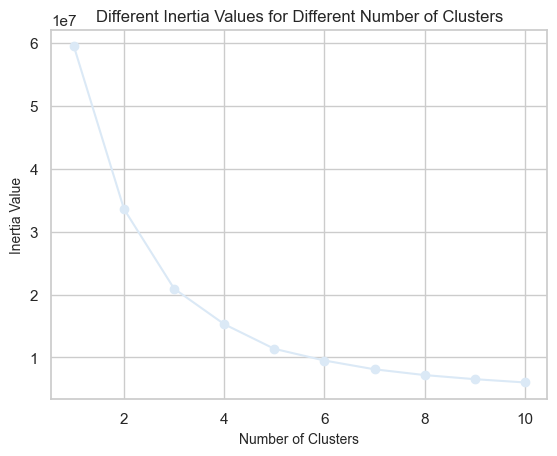

In [57]:
# plot the inertia curve
plt.plot(range(1,11),inertia_list_32)
plt.scatter(range(1,11),inertia_list_32)
plt.xlabel("Number of Clusters", size=10)
plt.ylabel("Inertia Value", size=10)
plt.title("Different Inertia Values for Different Number of Clusters", size=12)
plt.show()

In [58]:
## La siguiente librería reafirma la decicion de la seleccion de "codos" efectuada visualmente del grafico anterior
# Seleccion automatica del numero k 
kl_3 = KneeLocator(range(1, 11),
                 inertia_list_32, curve="convex",
                 direction="decreasing")
kl_3.elbow

3

In [59]:
kmeans_constants = {"init": "random", "n_init": 100, "max_iter": 500, "random_state": 42}

# --- Modelo K-means ---
model_kmeans_pca = KMeans(n_clusters = 3, **kmeans_constants)
model_kmeans_pca.fit(X_pca_2)

KMeans(init='random', max_iter=500, n_clusters=3, n_init=100, random_state=42)

In [60]:
# --- Evaluación del modelo kmeans ---
print(" ### K-MEANS ###")
print('Inertia: ', model_kmeans_pca.inertia_)
print('Silhouette Score: ', silhouette_score(X_pca_2, model_kmeans_pca.labels_))
print('Calinski harabasz score: ', calinski_harabasz_score(X_pca_2, model_kmeans_pca.labels_))

 ### K-MEANS ###
Inertia:  20930447.481126405
Silhouette Score:  0.43362423372105174
Calinski harabasz score:  5748.676788099464


**COMPARACIÓN DE RESULTADOS DEL ALGORITMO EJECUTADO EN DATASET ORIGINAL Y DATASET REDUCIDO**

- La reducción de la dimensionalidad si tiene un efecto en la metrica de la inercia, puesto que disminuye, es bueno por que se esta usando menos variables, el factor indica que estan menos correlacionadas.

- El indice de silueta es mayor, lo que indica un mejor resultado.

- El indice de Calinski también es más alto.

In [61]:
## Analizarlo vizualmente 
# Predicción de los clusters
Cluster_3 = model_kmeans.fit_predict(X_pca_2)

df_final['Cluster_3']= Cluster_3

# A partir de ahora, sólo trabajaremos con "df_final"
df_final.head(3)

,overall,age,height_cm,weight_kg,club_position,preferred_foot,pace,shooting,passing,dribbling,defending,physic,defending1,attacking1,skills1,mentality1,movement1,power,Cluster_1,Cluster_3
0,83,32,177,77,3,1,80.0,82.0,78.0,84.0,31.0,67.0,67,393,394,414,407,365,0,1
1,83,32,190,86,1,0,67.0,55.0,64.0,59.0,85.0,78.0,253,299,315,383,323,347,2,2
2,83,35,193,80,3,0,66.0,83.0,72.0,78.0,45.0,76.0,98,385,364,425,328,388,2,2


In [ ]:
### Gráfico de dispersión respecto al 'cluster_2'
# 3d scatterplot using matplotlib

fig = plt.figure(figsize = (15,15))
ax = fig.add_subplot(111, projection='2d')
ax.scatter(X_pca_2[Cluster_1 == 0,0],X_pca_2[Cluster_3 == 0,1],X_pca_2[Cluster_3 == 0,2], s = 40 , color = 'blue', label = "cluster 0")
ax.scatter(X_pca_2[Cluster_1 == 1,0],X_pca_2[Cluster_3 == 1,1],X_pca_2[Cluster_3 == 1,2], s = 40 , color = 'orange', label = "cluster 1")
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.legend()
plt.show()